# Site Zip Code Radius


Since we do not have any data on the routes, intended routes or intended destination for each driver when they leave the site location. We are broadly using location information for the surrounding radius of each site based on what we observed to be the distribution of trip lengths. 

## Workflow 


**Data Ingestion and Setup**
* Define constants such as file paths, ZIP field names, and the radius (40 miles) for distance filtering.
* Load the ZIP code shapefile (tl_2020_us_zcta520.shp) and the site ZIP code data from an Excel file (FusionSite_Services_Regional_Footprint_January_2025.xlsx).

**Data Pre Processing**
* Transform CRS for Accurate Distance Calculation
  * Check and transform the shapefile’s Coordinate Reference System (CRS) to EPSG:5070 for accurate distance measurements. Convert centroids to EPSG:4326 for latitude/longitude.
* Create Target ZIP Code Lookup: Filter the shapefile for the target ZIP codes from the regional site data manually add any missing ZIP codes with known latitude and longitude.

**Data Wrangling**
* Cross Join ZIP Code Data
  * Create a Spark DataFrame from the ZIP code data and cross join it with the target ZIP code DataFrame to generate all combinations of site and target ZIP codes.

* Add Target Coordinates to DataFrame: For each target ZIP code, add its latitude and longitude as literal columns to the DataFrame for easy access in distance calculations.

* Calculate Distance Using Haversine Formula
  * Apply the haversine_distance() UDF to compute the distance between each site ZIP code and the corresponding target ZIP code.
    * The UDF haversine_distance() computes the great-circle distance between two geographic points (latitude and longitude) using the Haversine formula.

* Filter by Radius: Filter the DataFrame to only retain rows where the distance is within the specified radius (40 miles).

**Save Intermediate Data**
* Sort and Cache Results
* Save Results




In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, radians, sin, cos, asin, sqrt, lit
from pyspark.sql.types import DoubleType, BooleanType
from shapely.geometry import shape
import geopandas as gpd
import json
import re
import os
from pyspark.sql.functions import array, struct
from pyspark.sql.types import ArrayType, StructType, StructField, StringType
from functools import partial
import pandas as pd
from pyspark.sql.functions import udf, col, broadcast, explode
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

In [0]:
spark = SparkSession.builder \
    .appName("ZipCodeRadiusSearch") \
    .getOrCreate()

In [0]:
# Haversine distance UDF for radius search
@udf(returnType=DoubleType())
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance between two points in miles"""
    import math
    
    # Convert decimal degrees to radians
    try:
        lon1, lat1, lon2, lat2 = map(
            lambda x: math.radians(float(x)), [lon1, lat1, lon2, lat2]
        )
        
        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        r = 3956  # Radius of earth in miles
        return float(c * r)
    except Exception as e:
        # Return a very large number if there's an error
        return float(9999999)

In [0]:
# Define Global Variable
DATA_PATH = "/dbfs/FileStore/tables/"
ZIP_FIELD = 'ZCTA5CE20'
RADIUS_MILES=40

In [0]:
shapefile_path = os.path.join(DATA_PATH, "tl_2020_us_zcta520.shp")
gdf = gpd.read_file(shapefile_path)

# Site data
fusionsite_regional_df =  spark.read.format("com.crealytics.spark.excel") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("/FileStore/tables/FusionSite_Services_Regional_Footprint_January_2025.xlsx")

In [0]:
# Drop Brand29
# Rename Brand1 to Brand
fusionsite_regional_df = fusionsite_regional_df.withColumnRenamed("Brand1", "Brand")
fusionsite_regional_df = fusionsite_regional_df.drop("Brand29")



In [0]:
from pyspark.sql import Row
from pyspark.sql.types import *

In [0]:
from pyspark.sql import Row
from pyspark.sql.types import *

# Define the schema explicitly matching your dataframe structure
schema = StructType([
    StructField("ID", DoubleType(), True),
    StructField("Brand", StringType(), True),
    StructField("Region", StringType(), True),
    StructField("State3", StringType(), True),
    StructField("City4", StringType(), True),
    StructField("Address", StringType(), True),
    StructField("PR", StringType(), True),
    StructField("RRT", StringType(), True),
    StructField("Shower", StringType(), True),
    StructField("RO", StringType(), True),
    StructField("Front Loader", StringType(), True),
    StructField("Septic", StringType(), True),
    StructField("Grease", StringType(), True),
    StructField("Concrete", StringType(), True),
    StructField("S&B", StringType(), True),
    StructField("Conex", StringType(), True),
    StructField("Mobile Offices", StringType(), True),
    StructField("Res Storage", StringType(), True),
    StructField("Refrigeration", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Number", DoubleType(), True),
    StructField("Street", StringType(), True),
    StructField("Unit Type", StringType(), True),
    StructField("Unit Number", StringType(), True),
    StructField("City25", StringType(), True),
    StructField("State26", StringType(), True),
    StructField("County", StringType(), True),
    StructField("Zip", DoubleType(), True),
    StructField("Country", StringType(), True)
])

# Find the last ID
last_id = fusionsite_regional_df.agg({"ID": "max"}).collect()[0][0]
new_id = last_id + 1

# Create the new row as a list of values in the correct order
new_row_values = [
    float(new_id),                 # ID
    "SAN ANGELO- TOPS SEPTIC",     # Brand
    None,                          # Region
    "Texas",                       # State3
    "San Angelo",                  # City4
    None,                          # Address
    None,                          # PR
    None,                          # RRT
    None,                          # Shower
    None,                          # RO
    None,                          # Front Loader
    None,                          # Septic
    None,                          # Grease
    None,                          # Concrete
    None,                          # S&B
    None,                          # Conex
    None,                          # Mobile Offices
    None,                          # Res Storage
    None,                          # Refrigeration
    31.49987,                      # Latitude
    -100.31583,                    # Longitude
    None,                          # Number
    None,                          # Street
    None,                          # Unit Type
    None,                          # Unit Number
    None,                          # City25
    None,                          # State26
    "Tom Green County",            # County
    76905.0,                       # Zip
    None                           # Country
]

# Create a dataframe with the explicit schema
new_row_df = spark.createDataFrame([new_row_values], schema)

# Append the new row to the existing dataframe
fusionsite_regional_df = fusionsite_regional_df.union(new_row_df)

# Show the new row
fusionsite_regional_df.filter(f"ID = {new_id}").show()

+----+--------------------+------+------+----------+-------+----+----+------+----+------------+------+------+--------+----+-----+--------------+-----------+-------------+--------+----------+------+------+---------+-----------+------+-------+----------------+-------+-------+
|  ID|               Brand|Region|State3|     City4|Address|  PR| RRT|Shower|  RO|Front Loader|Septic|Grease|Concrete| S&B|Conex|Mobile Offices|Res Storage|Refrigeration|Latitude| Longitude|Number|Street|Unit Type|Unit Number|City25|State26|          County|    Zip|Country|
+----+--------------------+------+------+----------+-------+----+----+------+----+------------+------+------+--------+----+-----+--------------+-----------+-------------+--------+----------+------+------+---------+-----------+------+-------+----------------+-------+-------+
|51.0|SAN ANGELO- TOPS ...|  NULL| Texas|San Angelo|   NULL|NULL|NULL|  NULL|NULL|        NULL|  NULL|  NULL|    NULL|NULL| NULL|          NULL|       NULL|         NULL|31.49

In [0]:
# Fill in missing value for Zip =  "28147" when Brand == "A Sani-Can" and Address == 1882 Briggs Rd Salisbury NC 28147
fusionsite_regional_df = fusionsite_regional_df.withColumn(
    "Zip", 
    F.when(
        (F.col("Brand") == "A Sani-Can") & (F.col("Address") == "1882 Briggs Rd Salisbury NC 28147"), 
        F.lit("28147")
    ).otherwise(F.col("Zip"))
)

# Assign this row ID 52
fusionsite_regional_df = fusionsite_regional_df.withColumn(
    "ID", 
    F.when(
        (F.col("Brand") == "A Sani-Can") & (F.col("Address") == "1882 Briggs Rd Salisbury NC 28147"), 
        F.lit(52)
    ).otherwise(F.col("ID"))
)

In [0]:
if gdf.crs is None or gdf.crs.to_string() != 'EPSG:5070':
    print(f"Converting from {gdf.crs} to EPSG:5070 for accurate distance measurements")
    gdf = gdf.to_crs('EPSG:5070')

target_zips = [
    str(int(float(zip))) for zip in fusionsite_regional_df.select('Zip').rdd.flatMap(lambda x: x).collect() 
    if pd.notnull(zip)
]

# Calculate centroids in the projected CRS
gdf['centroid'] = gdf.geometry.centroid

# Convert back to WGS84 for lat/lon
centroid_gdf = gpd.GeoDataFrame(geometry=gdf['centroid'], crs=gdf.crs)
centroid_gdf = centroid_gdf.to_crs('EPSG:4326')

# Extract latitude and longitude
gdf['latitude'] = centroid_gdf.geometry.y
gdf['longitude'] = centroid_gdf.geometry.x

Converting from EPSG:4269 to EPSG:5070 for accurate distance measurements


In [0]:
zip_df = spark.createDataFrame(gdf[[ZIP_FIELD, 'latitude', 'longitude']].copy())

# Create missing zips directly as a Spark DataFrame
missing_zips_schema = StructType([
    StructField("ZCTA5CE20", StringType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True)
])

missing_zips_data = [
    ("29604", 34.850750, -82.398956),
    ("18949", 40.389820, -75.144081)
]

missing_zips_df = spark.createDataFrame(missing_zips_data, schema=missing_zips_schema)

# Union the existing zip data with missing zips
zip_df = zip_df.unionByName(missing_zips_df)

In [0]:
# Get number of unique ZCTA5CE20 values in zip_df
print(f"Number of unique ZCTA5CE20 values in zip_df: {zip_df.select(ZIP_FIELD).distinct().count()}")

Number of unique ZCTA5CE20 values in zip_df: 33793


In [0]:
print(f"Number of unique ZIP values in zip_df: {fusionsite_regional_df.select('ZIP').distinct().count()}")

Number of unique ZIP values in zip_df: 48


In [0]:
# Extract target zip codes from fusionsite_regional_df_pandas and convert to a list

target_zips = [
    str(int(float(zip))) for zip in fusionsite_regional_df.select('Zip').rdd.flatMap(lambda x: x).collect() 
    if pd.notnull(zip)
]

# Create target zip code lookup
target_info = zip_df.filter(F.col(ZIP_FIELD).isin(target_zips))

# Check if all target zip codes were found
target_zips_found = [row[ZIP_FIELD] for row in target_info.select(ZIP_FIELD).collect()]
found_zips = set(target_zips_found)
missing_zips_set = set(target_zips) - found_zips

In [0]:
missing_zips_set 

set()

In [0]:
zip_df.printSchema()

root
 |-- ZCTA5CE20: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [0]:
display(fusionsite_regional_df)

ID,Brand,Region,State3,City4,Address,PR,RRT,Shower,RO,Front Loader,Septic,Grease,Concrete,S&B,Conex,Mobile Offices,Res Storage,Refrigeration,Latitude,Longitude,Number,Street,Unit Type,Unit Number,City25,State26,County,Zip,Country
1.0,Arkansas Portable Toilets,Gulf South,Arkansas,Little Rock,924 W 15th St. N Little Rock Arkansas 72114,X,X,X,X,null,null,null,null,null,null,null,null,null,34.768452,-92.277291,924.0,W 15th St,null,null,North Little Rock,AR,Pulaski County,72114.0,US
2.0,Arkansas Portable Toilets,Gulf South,Arkansas,Fayetteville,1975 Morningside Dr Fayetteville AR 72701,X,X,X,X,null,null,null,null,null,null,null,null,null,36.042659,-94.150036,1975.0,S Morningside Dr,null,null,Fayetteville,AR,Washington County,72701.0,US
11.0,Gotta Go Site Service Rentals,Gulf South,Mississippi,Jackson,120 US 49 N Jackson MS 39209,X,X,null,X,null,null,null,null,null,null,null,null,null,32.488432,-90.292417,120.0,US-49,null,null,Jackson,MS,Madison County,39209.0,US
40.0,American Johnny,Gulf South,Mississippi,Satillo,242 Old Saltillo Rd Satillo MS 38866,null,null,null,null,null,null,null,null,null,null,null,null,null,34.363529,-88.686359,242.0,Old Saltillo Rd,null,null,Saltillo,MS,Lee County,38866.0,US
23.0,Safety-Quip Portable Toilets,Gulf South,Tennessee,Memphis,4950 Getwell Rd. Memphis TN 38118,X,X,null,null,null,null,null,X,X,null,null,null,null,35.013868,-89.936507,4950.0,Getwell Rd,null,null,Memphis,TN,Shelby County,38118.0,US
49.0,Stamback Services,West,Arizona,Tucson,8939 S Eisenhower Rd Tucson AZ 85756,X,X,null,X,null,X,X,null,null,null,null,null,null,32.089109,-110.956899,8939.0,S Eisenhower Rd,null,null,Tucson,AZ,Pima County,85756.0,US
50.0,Stamback Services,West,Arizona,Wilcox,1111 E Maley St Willcox AZ 85643,X,X,null,null,null,X,X,null,null,null,null,null,null,32.243469,-109.818113,1111.0,E Maley St,null,null,Willcox,AZ,Cochise County,85643.0,US
28.0,A Clean Portoco,West,Texas,Laredo,402 Wildcat Dr. Laredo TX 78043,X,X,X,null,null,null,null,null,null,null,null,null,null,27.496295,-99.453422,402.0,Wildcat Dr,null,null,Laredo,TX,Webb County,78043.0,US
29.0,A Clean Portoco,West,Texas,Harlingen,2206 W Teege Ave Harlingen TX 78550,X,X,X,null,null,null,null,null,null,null,null,null,null,26.200354,-97.719826,2206.0,W Teege Ave,null,null,Harlingen,TX,Cameron County,78550.0,US
31.0,Redi2Go,West,Texas,Martindale,155 Ladybug Ln Martindale TX 78655,null,X,X,null,null,null,null,null,X,null,null,null,null,29.863864,-97.863737,155.0,Lady Bug Ln,null,null,Martindale,TX,Caldwell County,78655.0,US


In [0]:
# Drop rows from site_radius_by_zip_code where ID is null
fusionsite_regional_df = fusionsite_regional_df.filter(F.col("ID").isNotNull())

In [0]:
# Rename columns to match the target schema
target_info_renamed = target_info.select(
    F.col(ZIP_FIELD).alias("target_zip"),
    F.col("latitude").alias("target_lat"),
    F.col("longitude").alias("target_lon")
)

# Create the target DataFrame with the specified schema
target_schema = StructType([
    StructField("target_zip", StringType(), False),
    StructField("target_lat", DoubleType(), False),
    StructField("target_lon", DoubleType(), False)
])

# Convert to the specified schema
target_df = target_info_renamed.select(
    F.col("target_zip").cast(StringType()),
    F.col("target_lat").cast(DoubleType()),
    F.col("target_lon").cast(DoubleType())
)

# Broadcast the target DataFrame for better join performance
target_df = broadcast(target_df)

# Perform the cross join to get all combinations
print("Joining datasets...")
cross_df = zip_df.crossJoin(target_df)

print(f"Cross join complete with {cross_df.count()} rows")

Joining datasets...
Cross join complete with 1588271 rows


In [0]:
# We already have cross_df from the previous step with all combinations
# Now calculate distances for all combinations at once
print("Calculating distances...")
result_df = cross_df.withColumn(
    "distance_miles",
    haversine_distance(
        col("latitude"), 
        col("longitude"),
        col("target_lat"),
        col("target_lon")
    )
)

# Filter by radius
result_df = result_df.filter(col("distance_miles") <= RADIUS_MILES)

# Group the results by target zip
print("Processing all target zip codes at once...")
grouped_results = {}

# Get list of target zips for iteration
target_zip_list = [row["target_zip"] for row in target_df.select("target_zip").distinct().collect()]

for target_zip in target_zip_list:
    print(f"Processing results for target zip {target_zip}")
    
    # Filter for this specific target zip
    zip_result = result_df.filter(col("target_zip") == target_zip)
    
    # Select only necessary columns for output
    output_columns = [ZIP_FIELD, "distance_miles"]
    zip_result = zip_result.select(*output_columns)
    
    # Sort by distance
    zip_result = zip_result.orderBy("distance_miles")
    
    # Cache the results
    zip_result.cache()
    
    # Store in the results dictionary
    grouped_results[target_zip] = zip_result
    
    # Show sample of results
    print(f"Found {zip_result.count()} zip codes within {RADIUS_MILES} miles of {target_zip}")

Calculating distances...
Processing all target zip codes at once...
Processing results for target zip 79745
Found 17 zip codes within 40 miles of 79745
Processing results for target zip 40356
Found 68 zip codes within 40 miles of 40356
Processing results for target zip 19355
Found 438 zip codes within 40 miles of 19355
Processing results for target zip 79423
Found 42 zip codes within 40 miles of 79423
Processing results for target zip 30901
Found 62 zip codes within 40 miles of 30901
Processing results for target zip 37066
Found 97 zip codes within 40 miles of 37066
Processing results for target zip 38118
Found 90 zip codes within 40 miles of 38118
Processing results for target zip 43551
Found 140 zip codes within 40 miles of 43551
Processing results for target zip 37924
Found 89 zip codes within 40 miles of 37924
Processing results for target zip 37421
Found 92 zip codes within 40 miles of 37421
Processing results for target zip 28147
Found 114 zip codes within 40 miles of 28147
Proce

In [0]:
print(f"Found results for {len(grouped_results)} target zip codes")

Found results for 47 target zip codes


In [0]:
# Save fusionsite_regional_df to a csv
fusionsite_regional_df.write.mode("overwrite").csv(f"/FileStore/tables/fusionsite_regional_df.csv", header=True)

In [0]:
# Save results 
for target_zip, result_df in grouped_results.items():
    result_df.write.mode("overwrite").csv(f"/FileStore/intermediate_output/{target_zip}")

In [0]:
files = os.listdir("/dbfs/FileStore/intermediate_output")
table_names = [file for file in files if re.search(r"\d{5}$", file)]

In [0]:
dataframes = {
    table_name: spark.read.option("header", "false").csv(f"/FileStore/intermediate_output/{table_name}")
    for table_name in table_names
}

for table_name, df in dataframes.items():
    dataframes[table_name] = df.withColumnRenamed("_c0", "zip").withColumnRenamed("_c1", "distance")

In [0]:
# ONLY USING PANDAS FOR VISUALIZATION BELOW 
if not isinstance(zip_df, pd.DataFrame):
    zip_df = zip_df.toPandas()

In [0]:
# Create a mapping of zip codes to lat/lon
zip_to_coords = dict(zip(zip_df['ZCTA5CE20'], zip(zip_df['latitude'], zip_df['longitude'])))

# Convert all Spark DataFrames to pandas
pd_dataframes = {}
for core_zip, df in dataframes.items():
    if not isinstance(df, pd.DataFrame):
        pd_dataframes[core_zip] = df.toPandas()
    else:
        pd_dataframes[core_zip] = df

In [0]:
# Get a colormap with distinct colors for each core zip
num_core_zips = len(pd_dataframes)
colors = plt.cm.tab20(np.linspace(0, 1, num_core_zips))

In [0]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

In [0]:
zip_gdf = gdf
zip_gdf['ZCTA5CE20'] = zip_gdf['ZCTA5CE20'].astype(str)
zip_gdf = zip_gdf[(zip_gdf["longitude"] < 130) & (zip_gdf["latitude"] > 25)]

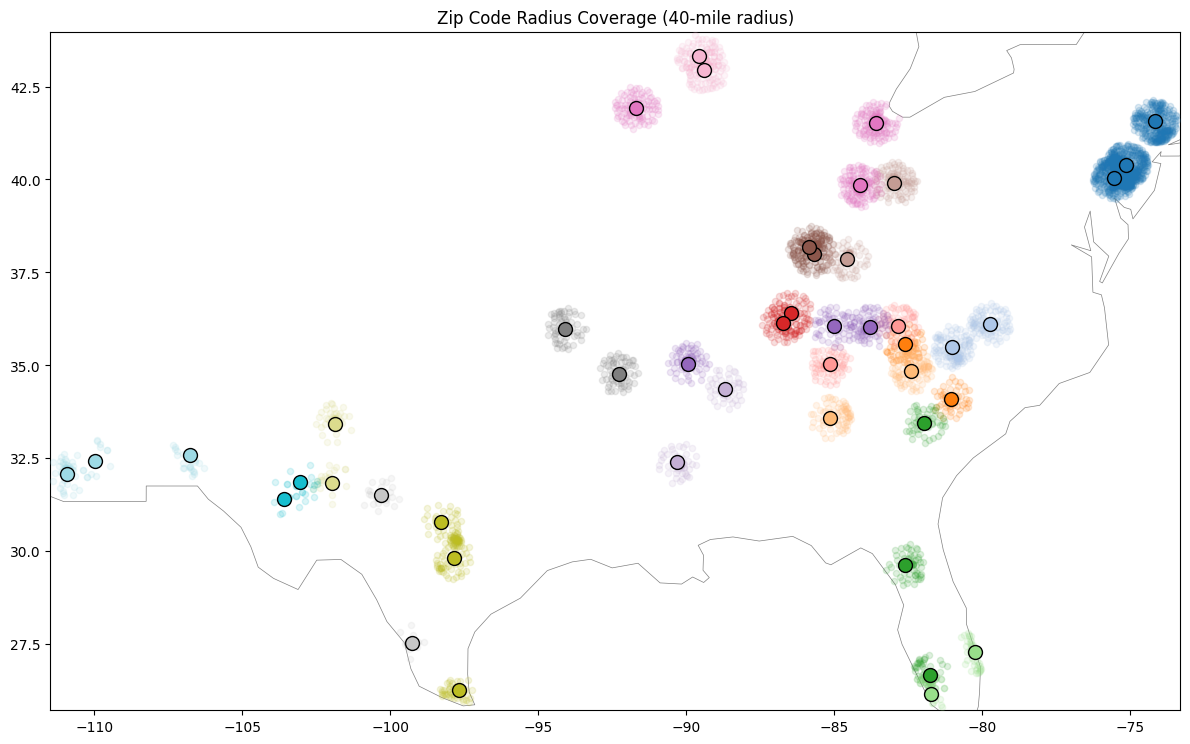

In [0]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Get distinct colors for each core zip
colors = plt.cm.tab20(np.linspace(0, 1, len(pd_dataframes)))

# Store all points for bounding
all_lats, all_lons = [], []

# Plot each core zip with circular radius
for i, (core_zip, df) in enumerate(pd_dataframes.items()):
    # Get coordinates for the core zip
    core_row = zip_df[zip_df['ZCTA5CE20'] == core_zip]
    if not core_row.empty:
        core_lat = core_row['latitude'].values[0]
        core_lon = core_row['longitude'].values[0]
        all_lats.append(core_lat)
        all_lons.append(core_lon)
        
        # Plot circular representation 
        ax.scatter(core_lon, core_lat, s=100, color=colors[i], edgecolor='black', zorder=5)

        for _, row in df.iterrows():
            zip_code = row['zip']
            zip_row = zip_df[zip_df['ZCTA5CE20'] == zip_code]
            if not zip_row.empty:
                zip_lat = zip_row['latitude'].values[0]
                zip_lon = zip_row['longitude'].values[0]
                all_lats.append(zip_lat)
                all_lons.append(zip_lon)
                ax.scatter(zip_lon, zip_lat, s=20, alpha=0.15, color=colors[i], zorder=3)

# Set boundaries
margin = 0.1
ax.set_xlim(min(all_lons) - margin, max(all_lons) + margin)
ax.set_ylim(min(all_lats) - margin, max(all_lats) + margin)

# Add state boundaries for reference
try:
    import geopandas as gpd
    states = gpd.read_file('GeoJSON:https://gist.github.com/krithin/7d694393e8a0b69dd3bd30336ecd46ad')
    states.boundary.plot(ax=ax, color='gray', linewidth=0.5)
except Exception:
    print("Could not add state boundaries")

plt.title('Zip Code Radius Coverage (40-mile radius)')
plt.tight_layout()

In [0]:
spark.stop()